https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style= 'white', context= 'notebook', palette= 'deep')

In [2]:
# 2. Load and check data : 파일 불러오기
# 2.1 Load data
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
IDtest= pd.read_csv('gender_submission.csv')

In [8]:
# 2.2 Outlier detection(Tukey)
def detect_outliers(df, n, features):
    outlier_indices= []
    
    # interate over features(columns)
    for col in features:
        Q1= np.percentile(df[col], 25) # 1st quartile(25%)
        Q3= np.percentile(df[col], 75) # 3st quartile(75%)
        IQR= Q3 - Q1 # Interquartile range (IQR)

        outlier_step= 1.5 * IQR # outlier step

        # Determine a list of indices of outliers for feature col
        outlier_list_col= df[(df[col]< Q1 - outlier_step) | (df[col]> Q3 + outlier_step)].index

        # append the found outlier indices for col to the list of outlier indices
        outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
    outlier_indices= Counter(outlier_indices)
    multiple_outliers= list(k for k, v in outlier_indices.items() if v>n)

    return multiple_outliers

Outliers_to_drop= detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])



In [9]:
train.loc[Outliers_to_drop] # show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [10]:
train= train.drop(Outliers_to_drop, axis= 0).reset_index(drop= True) # Drop outliers

In [12]:
# 2.3 joining train and test set
# join train and test datasets in order to obtain
# the same number of features during categorical conversion
train_len= len(train)
dataset= pd.concat(objs= [train, test], axis= 0).reset_index(drop= True)

In [13]:
# 2.4 check for null and missing values
# Fill empty and NaNs values with NaN
dataset= dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [14]:
# infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [17]:
# summarize data
# summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


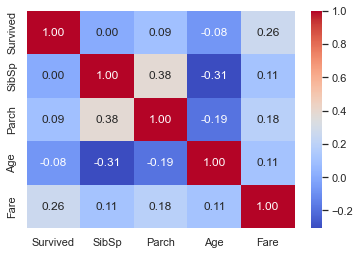

In [18]:
# 3. Feature analysis
# 3.1 Numerical values
# Correlation matrix between numerical values(SibSp Parch Age and Fare values) and Survived
g= sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot= True,
               fmt= '.2f', cmap= 'coolwarm')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


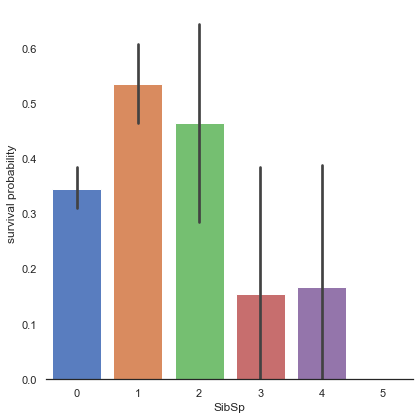

In [19]:
# Explore SibSp feature vs Survived
g= sns.factorplot(x= 'SibSp', y= 'Survived', data= train, kind= 'bar', size= 6, palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('survival probability')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


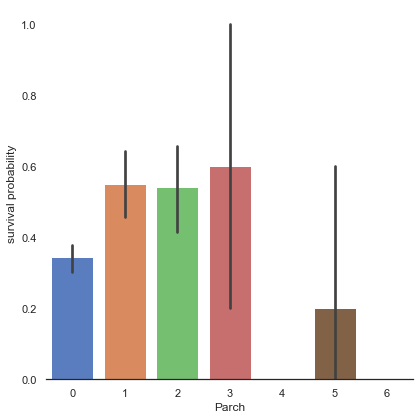

In [20]:
# Explore Parch feature vs Survived
g= sns.factorplot(x= 'Parch', y= 'Survived', data= train, kind= 'bar', size= 6, palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('survival probability')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


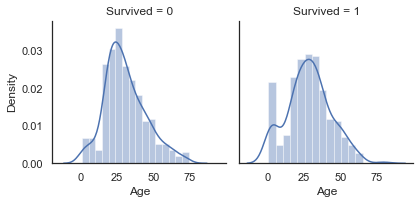

In [21]:
# Explore Age vs Survived
g= sns.FacetGrid(train, col= 'Survived')
g= g.map(sns.distplot, 'Age')

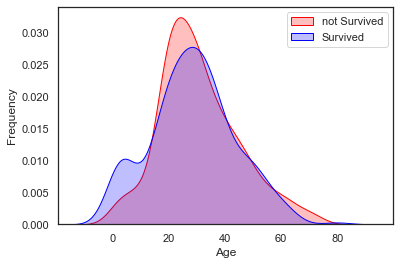

In [23]:
# Explore Age distibution
g= sns.kdeplot(train['Age'][(train['Survived']== 0) & 
                (train['Age'].notnull())], color= 'Red', shade= True)

g= sns.kdeplot(train['Age'][(train['Survived']== 1) &
                (train['Age'].notnull())], color= 'Blue', shade= True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')
g= g.legend(['not Survived', 'Survived'])

In [24]:
dataset['Fare'].isnull().sum()

1

In [25]:
# Fill Fare missing values with the median value
dataset['Fare']= dataset['Fare'].fillna(dataset['Fare'].median())

c:\Users\82109\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


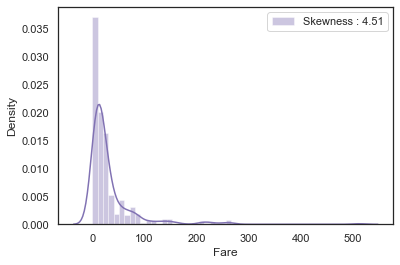

In [26]:
# Explore Fare distribution
g= sns.distplot(dataset['Fare'], color= 'm', label= 'Skewness : %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc= 'best')

In [27]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare']= dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

c:\Users\82109\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


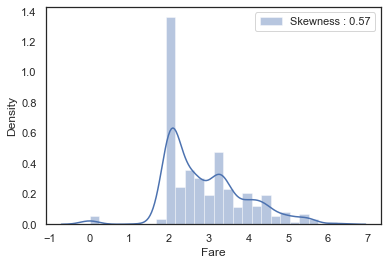

In [28]:
g= sns.distplot(dataset['Fare'], color= 'b', label= 'Skewness : %.2f'%(dataset['Fare'].skew()))
g= g.legend(loc= 'best')

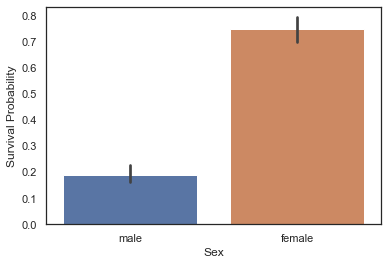

In [29]:
# 3.2 Categorical value
g= sns.barplot(x= 'Sex', y= 'Survived', data= train)
g= g.set_ylabel('Survival Probability')

In [30]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


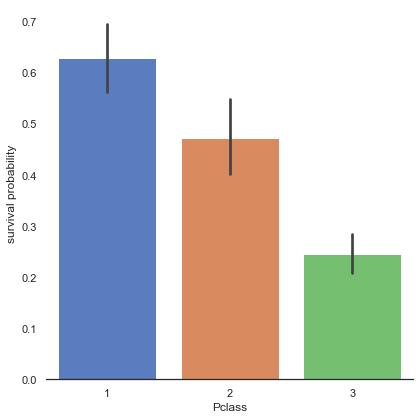

In [34]:
# Explore Pclass vs Survived
g= sns.factorplot(x= 'Pclass', y= 'Survived', data= train, kind= 'bar', size= 6, palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('survival probability')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


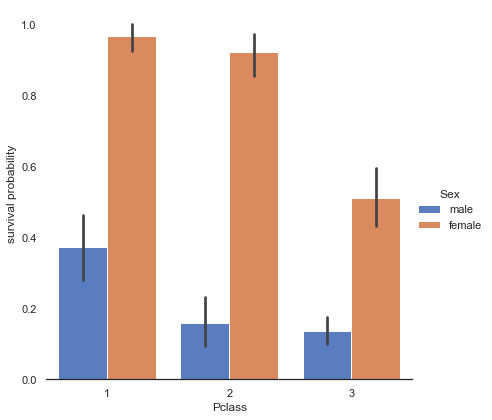

In [35]:
# Explore Pclass vs Survived by Sex
g= sns.factorplot(x= 'Pclass', y= 'Survived', hue= 'Sex', data= train,
                  size= 6, kind= 'bar', palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('survival probability')

In [36]:
dataset['Embarked'].isnull().sum()

2

In [37]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked']= dataset['Embarked'].fillna('S')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


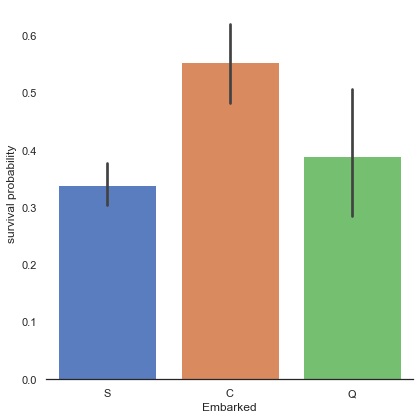

In [38]:
# Explore Embarked vs Survived
g= sns.factorplot(x= 'Embarked', y= 'Survived', data= train,
                  size= 6, kind= 'bar', palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('survival probability')

c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\82109\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


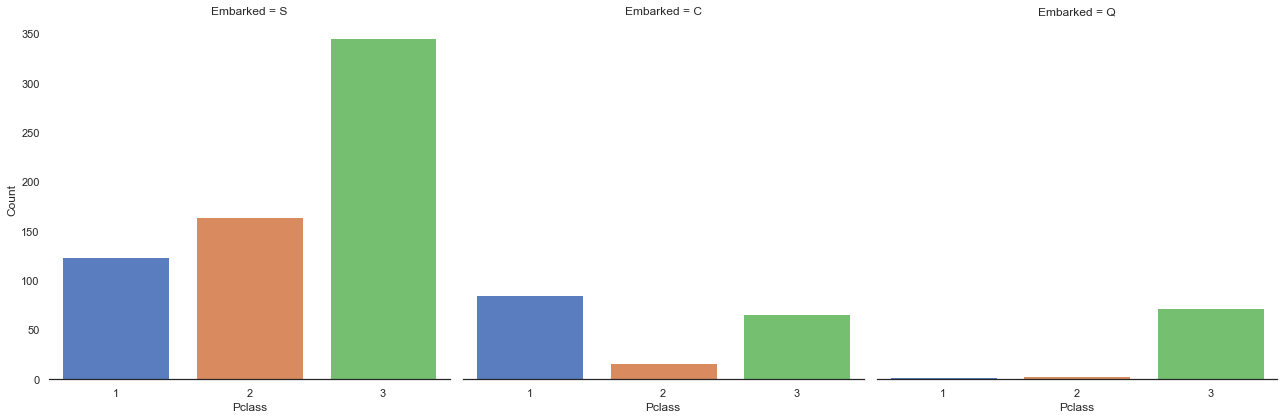

In [39]:
# Explore Pclass vs Embarked
g= sns.factorplot('Pclass', col= 'Embarked', data= train, 
                  size= 6, kind= 'count', palette= 'muted')
g.despine(left= True)
g= g.set_ylabels('Count')